In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=True)
df_test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=True)

In [ ]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df_train.shape, df_test.shape

((1462, 5), (114, 5))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [ ]:
df_train.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
df_test.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values(by='date')

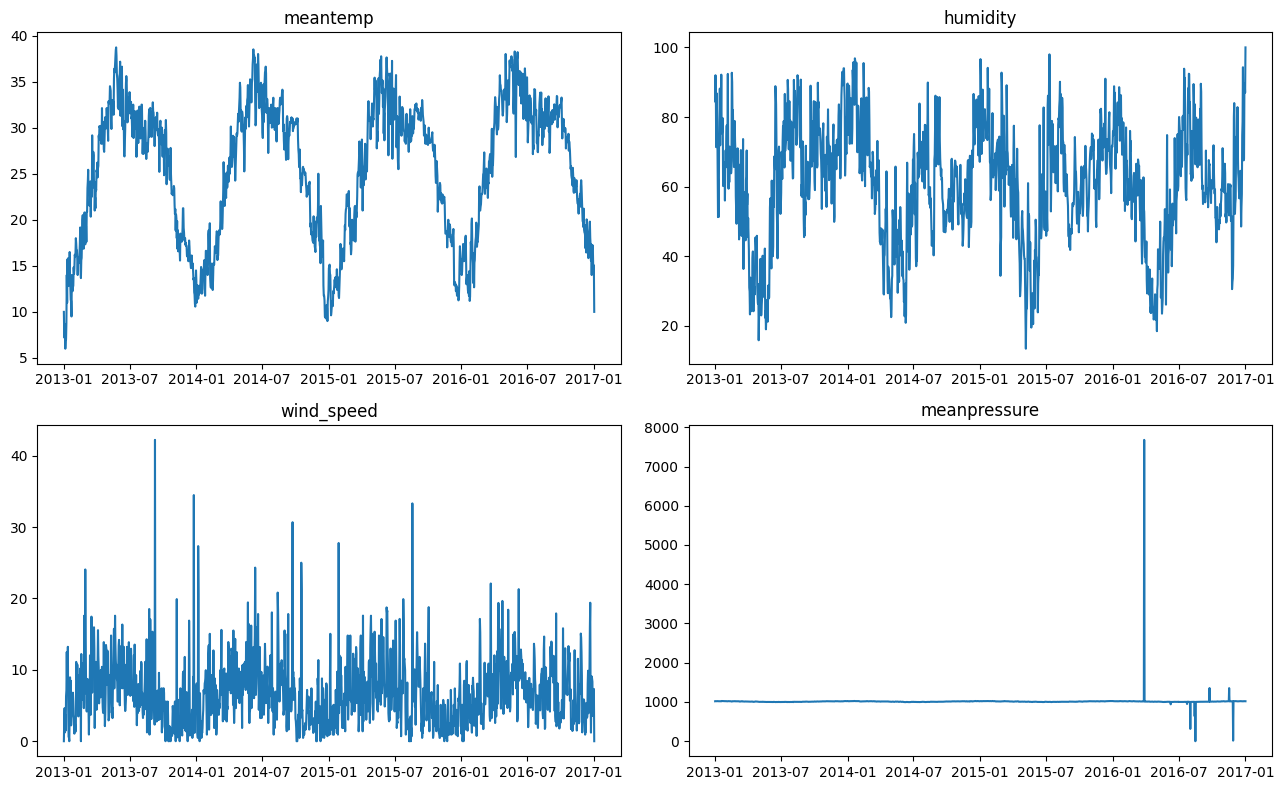

In [ ]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.plot(df_train['date'], df_train['meantemp'])
plt.title('meantemp')

plt.subplot(2,2,2)
plt.plot(df_train['date'], df_train['humidity'])
plt.title('humidity')

plt.subplot(2,2,3)
plt.plot(df_train['date'], df_train['wind_speed'])
plt.title('wind_speed')

plt.subplot(2,2,4)
plt.plot(df_train['date'], df_train['meanpressure'])
plt.title('meanpressure')
plt.tight_layout()
plt.show()

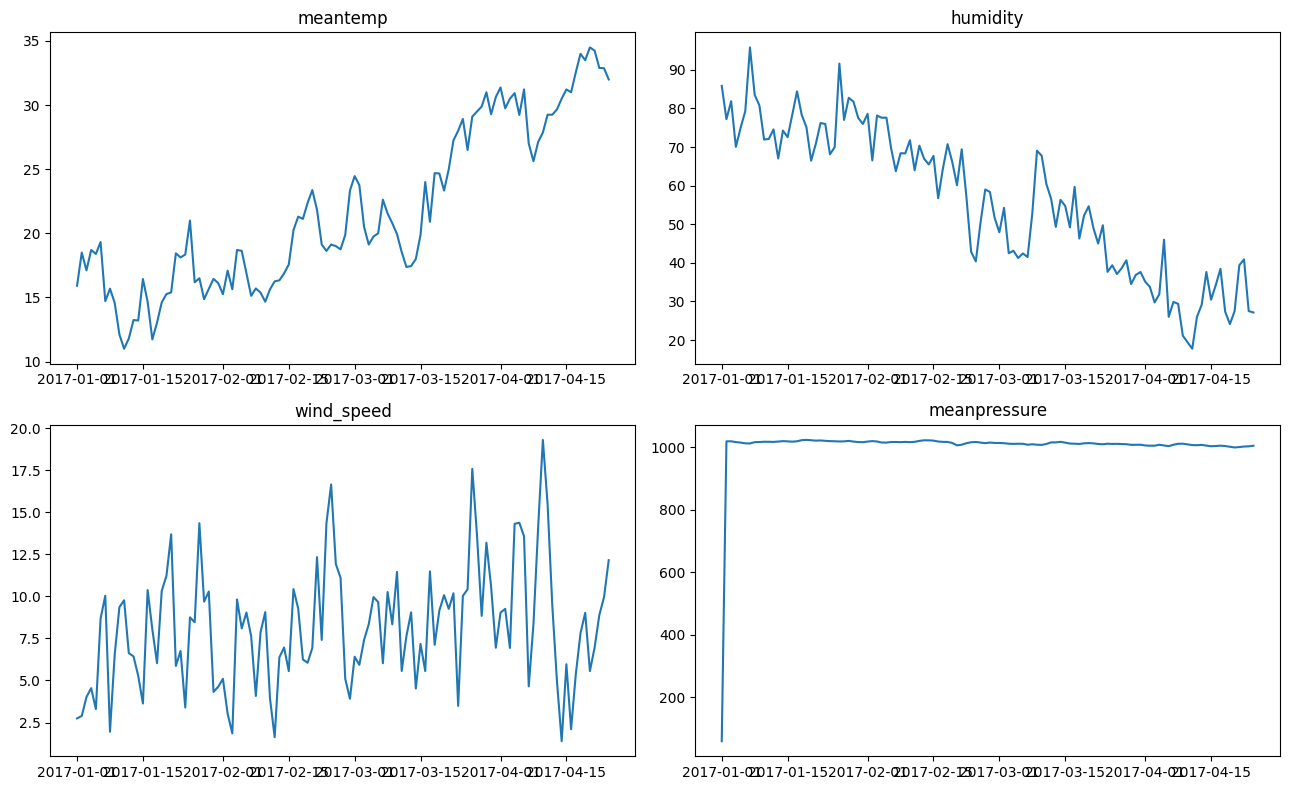

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values(by='date')


plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.plot(df_test['date'], df_test['meantemp'])
plt.title('meantemp')

plt.subplot(2,2,2)
plt.plot(df_test['date'], df_test['humidity'])
plt.title('humidity')

plt.subplot(2,2,3)
plt.plot(df_test['date'], df_test['wind_speed'])
plt.title('wind_speed')

plt.subplot(2,2,4)
plt.plot(df_test['date'], df_test['meanpressure'])
plt.title('meanpressure')
plt.tight_layout()
plt.show()

In [ ]:
def custom_df(df: pd.DataFrame, target_column: str, feature_columns: list, time_steps = 1) -> np.array:
    df_temp = df

    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    scaled_features = scaler_features.fit_transform(df_temp[feature_columns])
    scaled_target = scaler_target.fit_transform(df_temp[[target_column]])
    scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

    X_temp, y_temp = [], []
    for i in range(len(scaled_data) - time_steps):
        X_temp.append(scaled_data[i:(i + time_steps),: -1])
        y_temp.append(scaled_data[i + time_steps, -1])
    y_temp = y_temp[1:]
    X_temp = X_temp[:-1]
    return np.array(X_temp), np.array(y_temp), scaler_target

In [ ]:
def create_lag_1(df: pd.DataFrame, feature: str) -> pd.DataFrame :
    df['lag1'] = df[feature].diff()
    df = df.shift(-1)
    df = df.dropna()
    return df

# RNN - Recurrent Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.callbacks import EarlyStopping

meantemp

In [ ]:
df_train_meantemp = create_lag_1(df_train, 'meantemp')
df_test_meantemp = create_lag_1(df_test, 'meantemp')

X_train, y_train, scaler_target_train = custom_df(df_train_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test = custom_df(df_test_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_meantemp = scaler_target_test.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


humidity

In [ ]:
df_train_humidity = create_lag_1(df_train, 'humidity')
df_test_humidity = create_lag_1(df_test, 'humidity')

X_train, y_train, scaler_target_train = custom_df(df_train_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test = custom_df(df_test_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_humidity = scaler_target_test.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


wind_speed

In [ ]:
df_train_wind_speed = create_lag_1(df_train, 'wind_speed')
df_test_wind_speed = create_lag_1(df_test, 'wind_speed')

X_train, y_train, scaler_target_train  = custom_df(df_train_wind_speed,
                             'wind_speed',
                             ['humidity', 'meantemp', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_wind_speed,
                             'wind_speed',
                             ['humidity', 'meantemp', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_wind_speed = scaler_target_test.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


meanpressure

In [ ]:
df_train_meanpressure = create_lag_1(df_train, 'meanpressure')
df_test_meanpressure = create_lag_1(df_test, 'meanpressure')

X_train, y_train, scaler_target_train  = custom_df(df_train_meanpressure,
                             'meanpressure',
                             ['humidity', 'wind_speed', 'meantemp', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_meanpressure,
                             'meanpressure',
                             ['humidity', 'wind_speed', 'meantemp', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_meanpressure = scaler_target_test.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


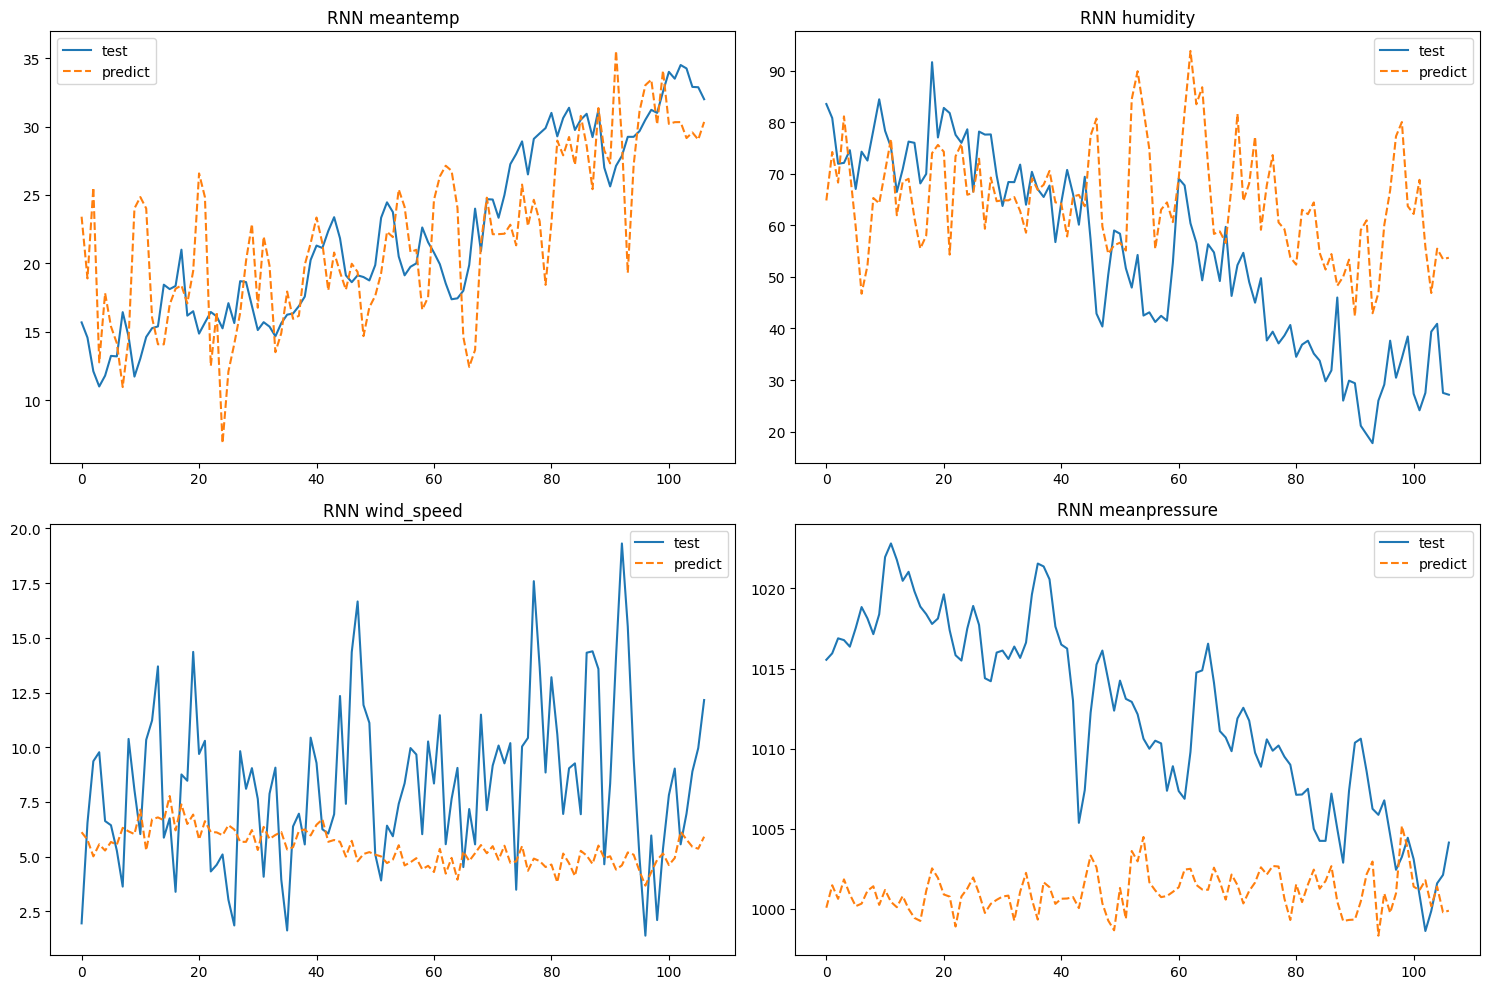

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('RNN meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('RNN humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('RNN wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('RNN meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): # средняя абсолютная ошибка в процентах
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_rnn_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_rnn_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_rnn_meantemp}%")
print(f"MAE meantemp: {mae_rnn_meantemp}\n")


mape_rnn_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_rnn_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_rnn_humidity}%")
print(f"MAE humidity: {mae_rnn_humidity}\n")


mape_rnn_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_rnn_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_rnn_wind_speed}%")
print(f"MAE wind_speed: {mae_rnn_wind_speed}\n")


mape_rnn_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_rnn_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_rnn_meanpressure}%")
print(f"MAE meanpressure: {mae_rnn_meanpressure}")

MAPE meantemp: 19.34975901126472%
MAE meantemp: 3.714470663780963

MAPE humidity: 41.85840915674553%
MAE humidity: 16.46271028496067

MAPE wind_speed: 46.10167110255767%
MAE wind_speed: 3.726871780607555

MAPE meanpressure: 1.1106143274079299%
MAE meanpressure: 11.274744759182859


# RNN with AttentionMechanism

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout

class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)

meantemp

In [ ]:
df_train_meantemp = create_lag_1(df_train, 'meantemp')
df_test_meantemp = create_lag_1(df_test, 'meantemp')

X_train, y_train, scaler_target_train = custom_df(df_train_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test = custom_df(df_test_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_meantemp = scaler_target_test.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


humidity

In [ ]:
df_train_humidity = create_lag_1(df_train, 'humidity')
df_test_humidity = create_lag_1(df_test, 'humidity')

X_train, y_train, scaler_target_train = custom_df(df_train_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test = custom_df(df_test_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_humidity = scaler_target_test.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


wind_speed

In [ ]:
df_train_wind_speed = create_lag_1(df_train, 'wind_speed')
df_test_wind_speed = create_lag_1(df_test, 'wind_speed')

X_train, y_train, scaler_target_train  = custom_df(df_train_wind_speed,
                             'wind_speed',
                             ['humidity', 'meantemp', 'meanpressure', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_wind_speed,
                             'wind_speed',
                             ['humidity', 'meantemp', 'meanpressure', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_wind_speed = scaler_target_test.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


meanpressure

In [ ]:
df_train_meanpressure = create_lag_1(df_train, 'meanpressure')
df_test_meanpressure = create_lag_1(df_test, 'meanpressure')

X_train, y_train, scaler_target_train  = custom_df(df_train_meanpressure,
                             'meanpressure',
                             ['humidity', 'wind_speed', 'meantemp', 'lag1'],
                             time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_meanpressure,
                             'meanpressure',
                             ['humidity', 'wind_speed', 'meantemp', 'lag1'],
                             time_steps = 5)

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test)
pred_inv_meanpressure = scaler_target_test.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


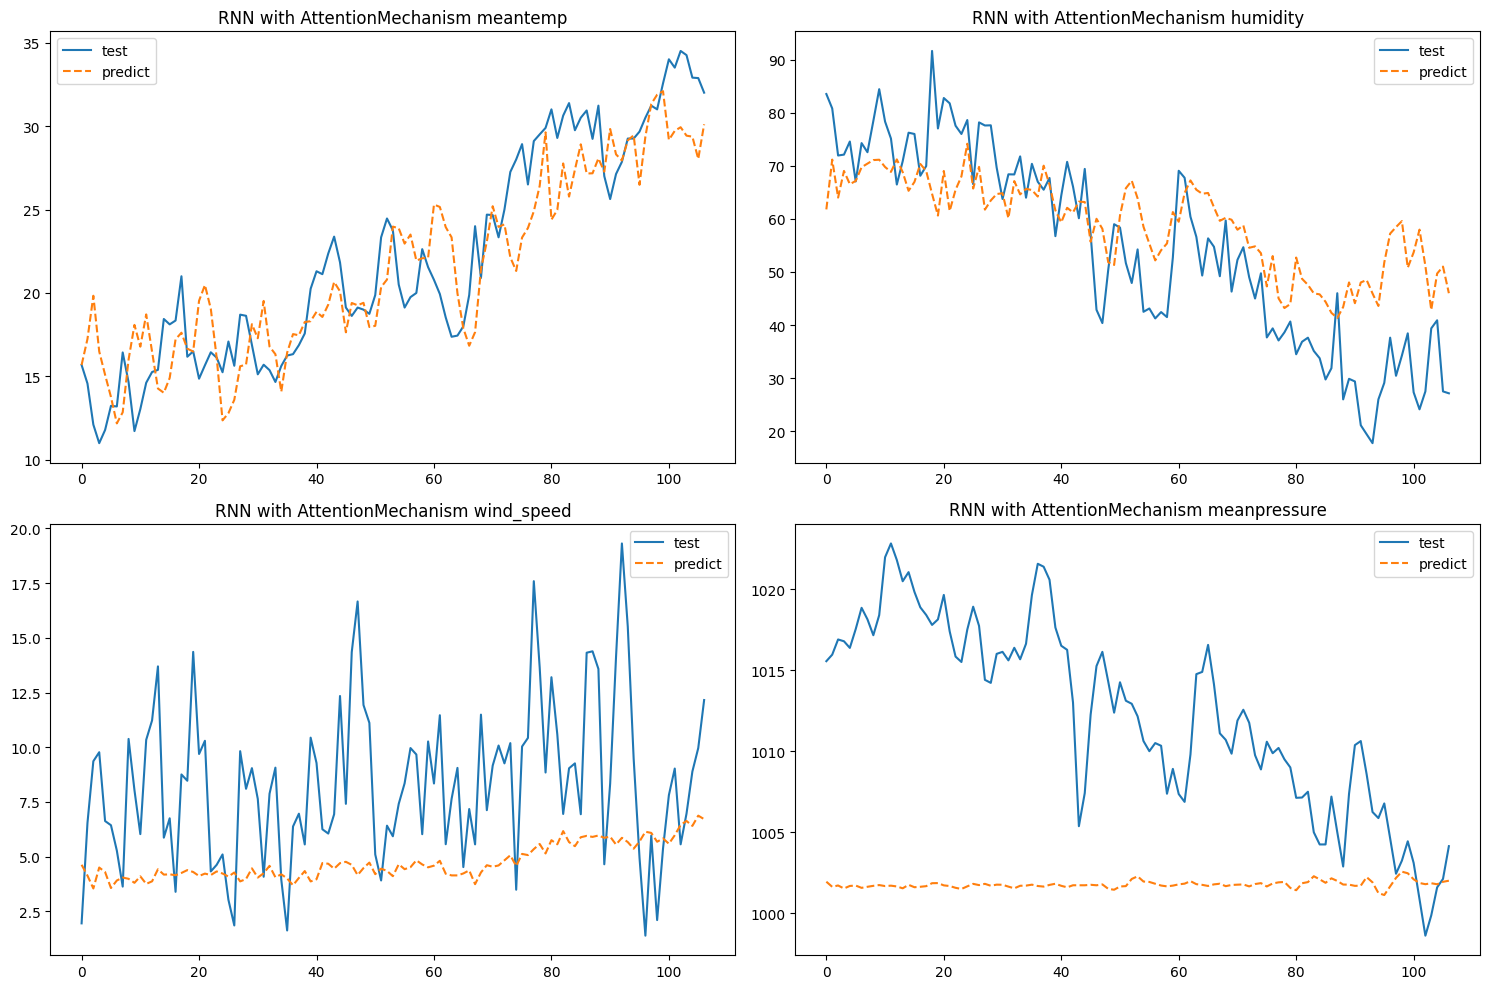

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_rnn_att_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_rnn_att_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_rnn_att_meantemp}%")
print(f"MAE meantemp: {mae_rnn_att_meantemp}\n")


mape_rnn_att_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_rnn_att_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_rnn_att_humidity}%")
print(f"MAE humidity: {mae_rnn_att_humidity}\n")


mape_rnn_att_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_rnn_att_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_rnn_att_wind_speed}%")
print(f"MAE wind_speed: {mae_rnn_att_wind_speed}\n")


mape_rnn_att_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_rnn_att_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_rnn_att_meanpressure}%")
print(f"MAE meanpressure: {mae_rnn_att_meanpressure}")

MAPE meantemp: 12.752814325780667%
MAE meantemp: 2.5674400885123236

MAPE humidity: 27.143298566375655%
MAE humidity: 10.670177218669366

MAPE wind_speed: 47.87289158866193%
MAE wind_speed: 4.02698006414002

MAPE meanpressure: 1.043386377071268%
MAE meanpressure: 10.593290776268141


# Total

In [ ]:
data = {
    'Model': ['RNN', 'RNN with AttentionMechanism'],
    'MAPE meantemp': [mape_rnn_meantemp, mape_rnn_att_meantemp],
    'MAPE humidity': [mape_rnn_humidity, mape_rnn_att_humidity],
    'MAPE wind_speed': [mape_rnn_wind_speed, mape_rnn_att_wind_speed],
    'MAPE meanpressure': [mape_rnn_meanpressure, mape_rnn_att_meanpressure],
    'MAE meantemp': [mae_rnn_meantemp, mae_rnn_att_meantemp],
    'MAE humidity': [mae_rnn_humidity, mae_rnn_att_humidity],
    'MAE wind_speed': [mae_rnn_wind_speed, mae_rnn_att_wind_speed],
    'MAE meanpressure': [mae_rnn_meanpressure, mae_rnn_att_meanpressure]
}

models = pd.DataFrame(data)
models

,Model,MAPE meantemp,MAPE humidity,MAPE wind_speed,MAPE meanpressure,MAE meantemp,MAE humidity,MAE wind_speed,MAE meanpressure
0,RNN,19.349759,41.858409,46.101671,1.110614,3.714471,16.462710,3.726872,11.274745
1,RNN with AttentionMechanism,12.752814,27.143299,47.872892,1.043386,2.567440,10.670177,4.026980,10.593291
